In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, parser = "auto", as_frame=False)
mnist.keys()
#The API of fetch_openml changed between versions. In earlier versions,
#it returns a numpy.ndarray array. Since 0.24.0 (December 2020),
#as_frame argument of fetch_openml is set to auto (instead of False as default option earlier)
#which gives you a pandas.DataFrame for the MNIST data.
#You can force the data read as a numpy.ndarray by setting as_frame = False.

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

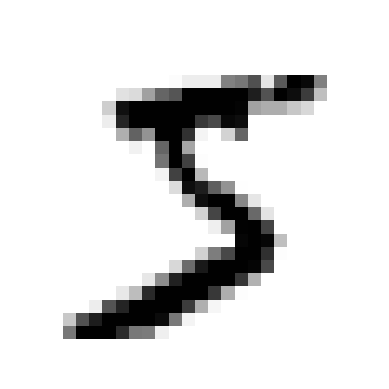

In [10]:
# Plotting an image in the dataset.

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Transform the dataframe into an array. Check the first value
some_digit = X[0]
# Reshape it to (28,28). Note: 28 x 28 = 7064, if the reshaping doesn't 
# meet this you are not able to show the image
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis('off')
plt.show()

In [11]:
y[0]

'5'

In [12]:
y = y.astype(np.uint8)

In [14]:
#Separate the training set from the test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [15]:
#Training a Binary Classifier
y_train_5 = (y_train == 5) #True for all 5s. False for all other digits.
y_test_5 = (y_test == 5)

In [16]:
#Use Stochastic Gradient Descent (SGD); capable of handling large datasets efficiently
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

In [17]:
#Evaluate model using cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index, in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [18]:
#use cross_val_score() to evaluate SGDClassifier model, using K-fold cross-validation w/ 3 folds
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [19]:
#93% accuracy (ratio of correct predictions)
# check the "not-5" cases too

In [20]:
from sklearn.base import BaseEstimator

class Not5Classifier (BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)
    
not_5_clf = Not5Classifier()
cross_val_score(not_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [21]:
#Remember that only 10% of the images are 5s, thus you will always be 90% right
#if you guess that an image is not a 5
#'accuracy' is not a preferred oerformance measure for classifiers,
#esp. when dealing with skewed datasets

In [22]:
#Use Confusion Matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [23]:
y_train_perfect_predictions = y_train_5 #assuming we reached 'perfection'
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [24]:
#Check the 'precison' and 'recall' metrics
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 3530 / (3530 + 687)
recall_score(y_train_5, y_train_pred) # 3530 / (3530 + 1891)

0.6511713705958311

In [25]:
#combine precision and recall metrics into a single metric called f1_score
#f1_score is the 'harmonic mean' of precison and recall
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [26]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [27]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [28]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [29]:
#This confirms that raising the threshold decreases recall.

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method='decision_function')

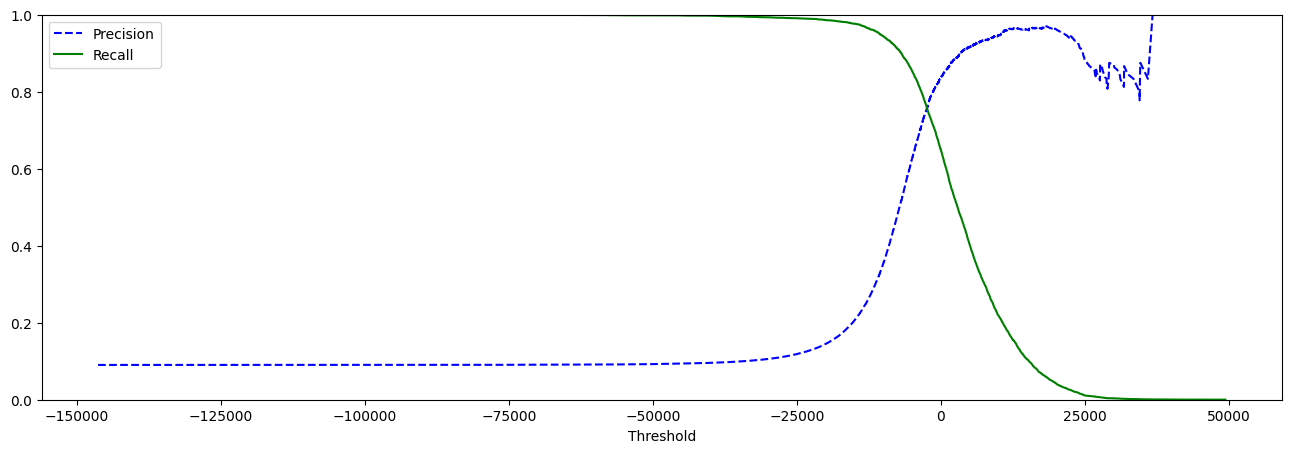

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Plotting the results

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(16,5))
    # Removing last value to avoid divide by zero in precision computation
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

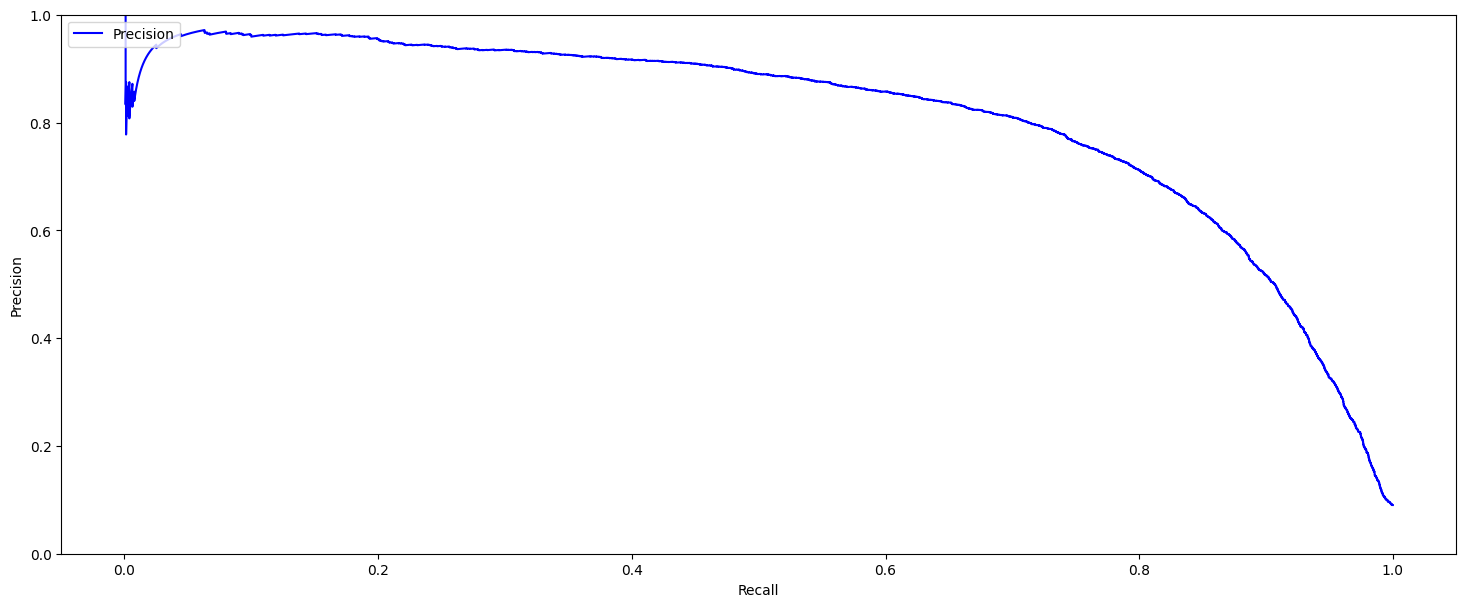

In [32]:
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(18,7))
    plt.plot(recalls[:-1], precisions[:-1], "b-", label="Precision")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_vs_recall(precisions, recalls)
plt.show()

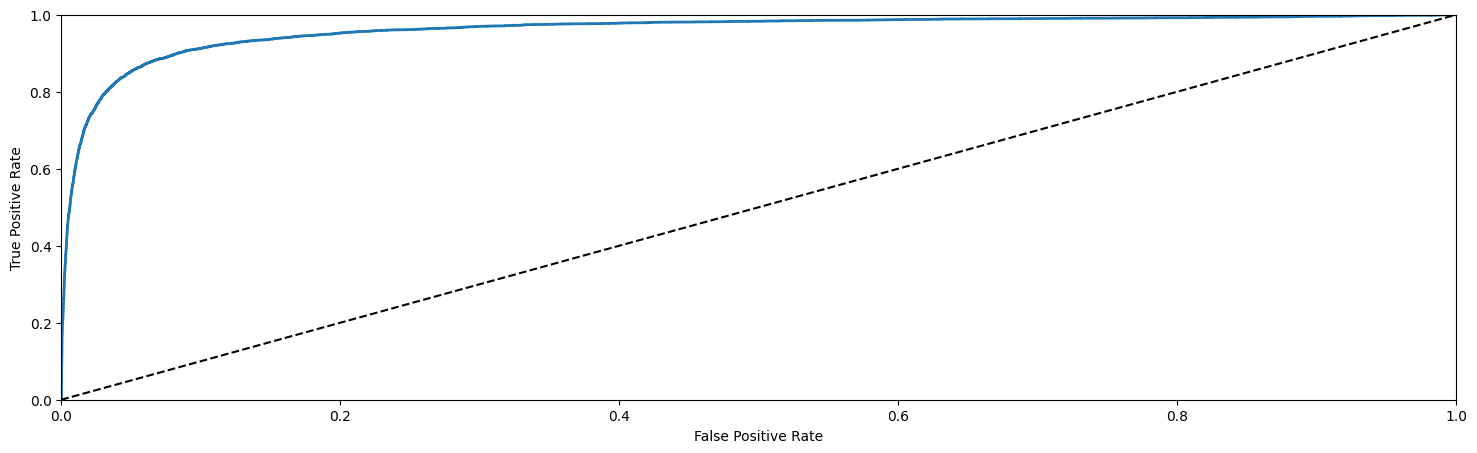

In [33]:
#ROC Curve - plots the true positive rate (another name for recall)
#against the false positive rate(FPR)

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve (y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.figure(figsize=(18, 5))
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') #Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()


In [34]:
#Compare classifiers by measuring the 'area under the curve' (AUC).
#A perfect classifier will have a ROC AUC equal to 1, whereas
#a purely random classifier will have ROC AUC equal to 0.5

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [35]:
#the ROC is not a good metric for the model because there are only few positives (5s)
#Rule of thumb: use PR curve whenever the positive class is rare,
#or when you care  more about the false positives than the false negatives.
#Otherwise, use the ROC curve.

In [36]:
#Train RandomForestClassifier and compare its ROC curve and ROC AUC score tp those of the SGDClassifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')
y_probas_forest

array([[0.1, 0.9],
       [1. , 0. ],
       [0.9, 0.1],
       ...,
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ]])

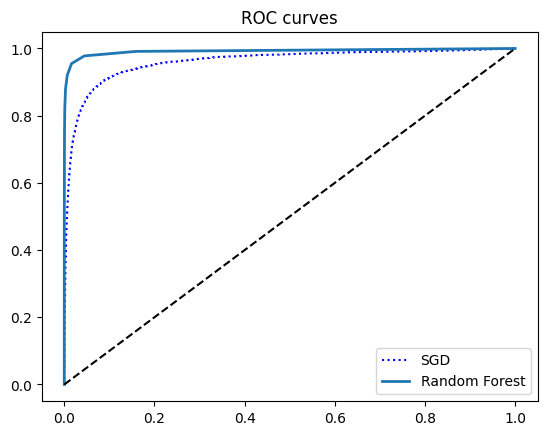

In [37]:
#The ROC curve expects 'labels' and 'scores'
#instead of scores, use the class's probabilities as the score

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, "b:", label="SGD")
ax.plot(fpr_forest, tpr_forest, linewidth=2, label="Random Forest")
ax.plot([0, 1], [0, 1], 'k--')
ax.legend(loc=4);
ax.set_title('ROC curves');

In [38]:
#The RandomForestClassifier’s ROC curve looks much better
#than the SGDClassifier’s as it comes much closer to the top-left corner.
#As a result, its ROC AUC score is also significantly better.

# ROC auc score of SGDClassifier

from sklearn.metrics import roc_auc_score
print("The ROC AUC value for SGDClassifier : ", roc_auc_score(y_train_5, y_scores))
print("The ROC AUC value for Random Forest Classifier is : " , roc_auc_score(y_train_5, y_scores_forest))

The ROC AUC value for SGDClassifier :  0.9604938554008616
The ROC AUC value for Random Forest Classifier is :  0.9920527492698306


In [39]:
#Binary classifiers distinguish between two classes,
#multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

In [40]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) #y_train NOT y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [41]:
#under the hood, SciKit-Learn used the OvO strategy; it rained 45 binary classifiers
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [42]:
np.argmax(some_digit_scores)

5

In [43]:
svm_clf.classes_[5]

5

In [44]:
#The highest score isindeed the one corresponding to 5

In [45]:
#Try OneVsRestClassifier
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

In [46]:
#Train an SGDClassifier
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

#SGDClassifier did not have to run OvO or OvR because it can directly classify instances into multiple instances

array([3], dtype=uint8)

In [47]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [48]:
#The classifier is not confident about its prediction:
#almost all scores are largely negative, while class 3 has a score of 1823.73.
#The model has a huge doubt regarding class 5, which gets a score of -26188.91!

In [50]:
#Evaluate the classifier using cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [55]:
#Scale the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

In [56]:
#Improve the model by performing error analysis 
#First, analyze the Confusion Matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

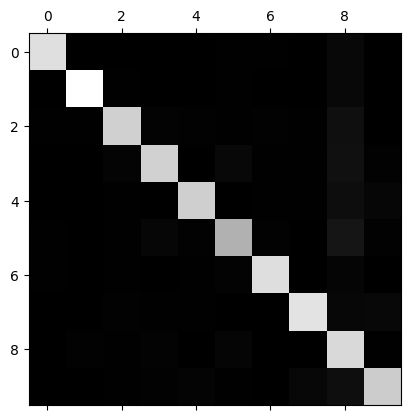

In [57]:
#For better visual analysis/insight, represent the data thru an image
#Use Matplotlib's matshow() function:

plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [ ]:
#Confusion matrix looks good; most images are on the main diagonal,
#which means they were classified correctly
#The 5s look slightly darker than the other digits, which could mean
#that there are fewer images of 5s in the dataset
#or the classifies does not perform as well on 5s on other digits.
#In fact you can verify that both are the case.


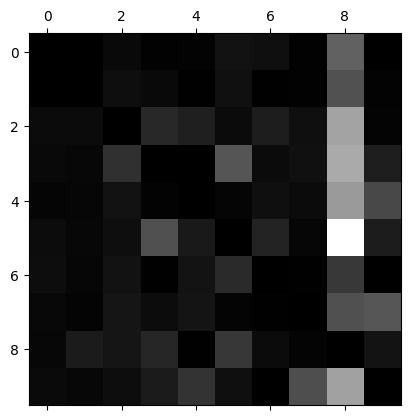

In [58]:
#Get insights on the errors by plotting it
#Divide each value in the confusion matrix by the number of images in the corresponding class
#so that you error rates instead of absolute numbers of erros (which would make
#abundant classes look unfairly bad)

row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

#Fill diagonal with zeros to keep only the errors; plot the result.
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

In [59]:
#Rows represent actual classes
#Columns represent predicted classes
#(e.g. Column 8 is quite bright, which tells that many images get miscalssified as 8s.
#However the row for class 8 is not that bad , telling that in general get properly classified as 8s.)

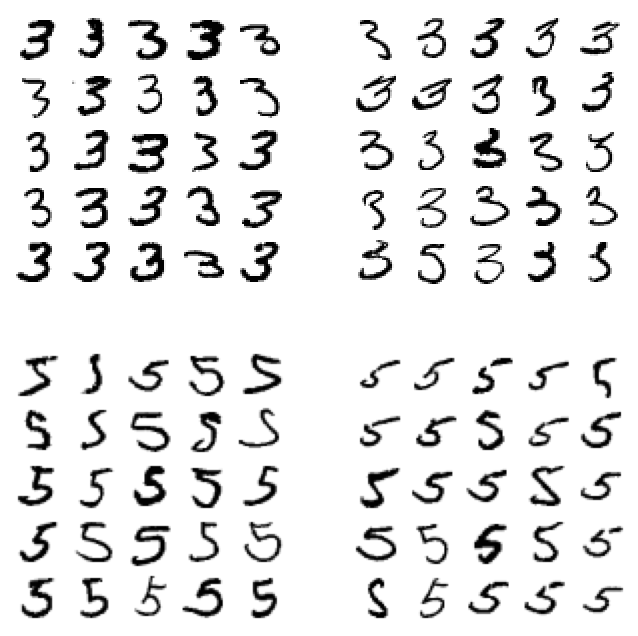

In [67]:
#Analyze individual errors to get insights on what your classifier is doing and why it is failing
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


import matplotlib
import matplotlib.pyplot as plt
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [68]:
#One way to reduce the 3/5 confusion is to preprocess
#the images to ensure that they are well centered and not too rotated.
#This will probably help reduce other errors as well.

In [70]:
#Multilabel Classification
#Instead of assigning each instance into just one class, try your classifier
#to output multiple classes for each instance

from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]  # np.c_ is used to concatenate the two arrays element wise
y_multilabel
#The code xreates a y_multilabel array containing two large target labels for each digit image:
#the first indicates whether or not the digit is large (7, 8, or 9) and the second indicates
#whether it is ever or not it is odd.

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [71]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
#The two lines create a KNeighborsClassifier instance (which supports multilabel classification,
#though not all classifiers do), and we train it using multiple target arrays
knn_clf.predict([some_digit])

array([[False,  True]])

In [72]:
#The code gets it right! The digit 5 is indeed nott large (False) and odd (True)

In [74]:
#Evaluate the multilabel classifier thru measuring F1 score for each individual label
#(or any other binary) classifier metric discussed earlier

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.976410265560605

In [75]:
#change average = "weighted" in the preceeding code considering that only 10% of the images are 5,
#evaluating it non-5 will always be 90% true

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "weighted")

0.9778357403921755

In [77]:
#Multioutput Classification / Multioutput-multiclass classification
#It's simply a generalization of multilabel classification where each label can be multiclass
#Build this by constructing a system that removes noise from images.
#It will take as input a noisy digit image, and it will hopefully (output) a clean digit image,
#represented as an array of pixel intensities, just like this dataset (MNIST images).
#Notice that the classifier's output is multilabel (one label per pixel) and each label can have multiple
#values (pixel intensity ranges from 0 to 255). It is thus an example of multioutput classification system.

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test
#Return random integers from low (inclusive) to high (exclusive).

#Return random integers from the “discrete uniform” distribution of the specified dtype in the “half-open” 
#interval [low, high). If high is None (the default), then results are from [0, low).


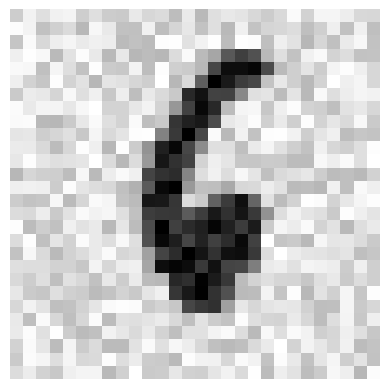

In [78]:
# Displaying a noisy digit from the test set, normally you do not snoop
# on the test set.

some_index = 1400

def plot_digit(digit):
    image = digit.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary,
               interpolation='nearest')
    plt.axis('off')
    plt.show()

plot_digit(X_test_mod[some_index])

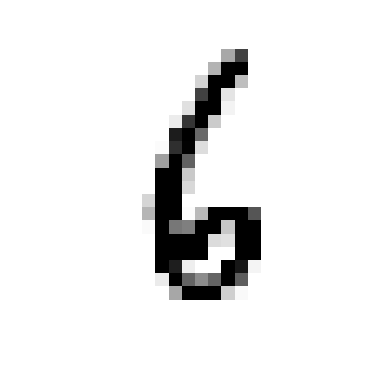

In [79]:
# The same digit after the model removes the noise it finds.

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

In [80]:
#Looks good and close enough to the target!